<a href="https://colab.research.google.com/github/Munal16/Toxic-Text-Classifier-/blob/main/Toxic_vs_Non_Toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers accelerate torch scikit-learn nltk seaborn matplotlib pandas


In [2]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_json(
    "hf://datasets/mteb/toxic_conversations_50k/train.jsonl",
    lines=True
)

df_toxic = df[df['label'] == 1]
df_nontoxic = df[df['label'] == 0]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df_toxic_up = resample(
    df_toxic,
    replace=True,
    n_samples=10000,
    random_state=42
)


In [5]:
df_nontoxic_down = resample(
    df_nontoxic,
    replace=False,
    n_samples=20000,
    random_state=42
)


In [6]:
df_balanced = pd.concat([df_toxic_up, df_nontoxic_down])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
df_balanced['label'].value_counts()


,count
label,
0,20000
1,10000


In [8]:
def clean_text_bert(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [9]:
df_balanced['clean_text'] = df_balanced['text'].apply(clean_text_bert)


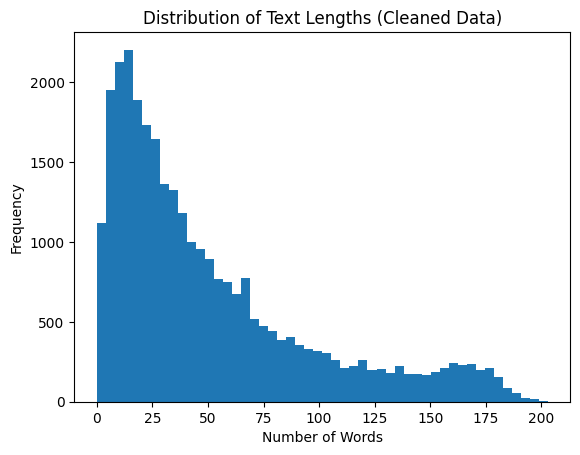

In [10]:
df_balanced['text_length'] = df_balanced['clean_text'].apply(lambda x: len(x.split()))

plt.hist(df_balanced['text_length'], bins=50)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths (Cleaned Data)")
plt.show()


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'],
    df_balanced['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['label']
)


In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=128
)


In [14]:
class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [15]:
train_dataset = ToxicDataset(train_encodings, y_train)
test_dataset = ToxicDataset(test_encodings, y_test)


In [16]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


In [18]:
training_args = TrainingArguments(
    output_dir="./bert_cleaned_results",
    eval_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [20]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.313700,0.261675,0.926333
2,0.064500,0.255698,0.947333
3,0.000900,0.320771,0.942833


TrainOutput(global_step=9000, training_loss=0.18602826030966307, metrics={'train_runtime': 2113.2336, 'train_samples_per_second': 34.071, 'train_steps_per_second': 4.259, 'total_flos': 4735998996480000.0, 'train_loss': 0.18602826030966307, 'epoch': 3.0})

In [21]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 0.3207709491252899,
 'eval_accuracy': 0.9428333333333333,
 'eval_runtime': 41.3584,
 'eval_samples_per_second': 145.073,
 'eval_steps_per_second': 18.134,
 'epoch': 3.0}

In [22]:
import numpy as np
import torch

predictions = trainer.predict(test_dataset)

logits = predictions.predictions
y_true = predictions.label_ids

y_pred = np.argmax(logits, axis=1)
y_prob = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()


In [23]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Non-Toxic", "Toxic"]
))


              precision    recall  f1-score   support

   Non-Toxic       0.98      0.93      0.96      4000
       Toxic       0.88      0.96      0.92      2000

    accuracy                           0.94      6000
   macro avg       0.93      0.95      0.94      6000
weighted avg       0.95      0.94      0.94      6000



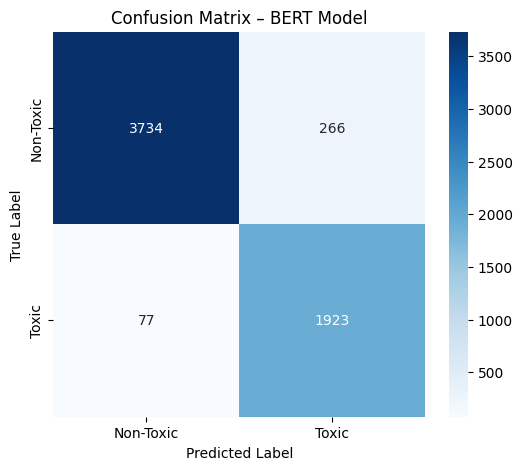

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Toxic", "Toxic"],
    yticklabels=["Non-Toxic", "Toxic"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – BERT Model")
plt.show()


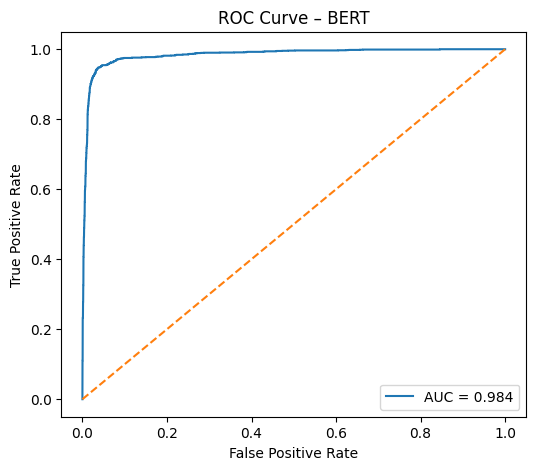

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – BERT")
plt.legend()
plt.show()


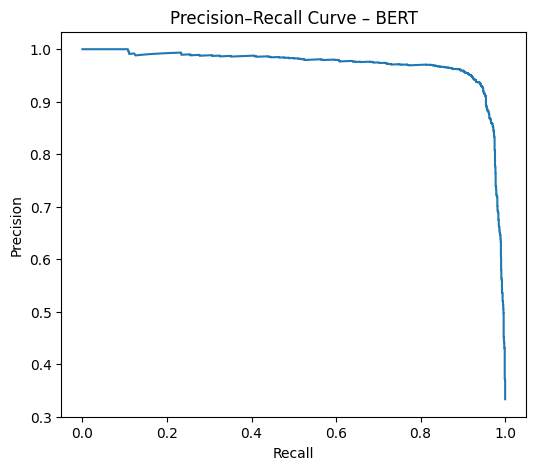

In [26]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – BERT")
plt.show()


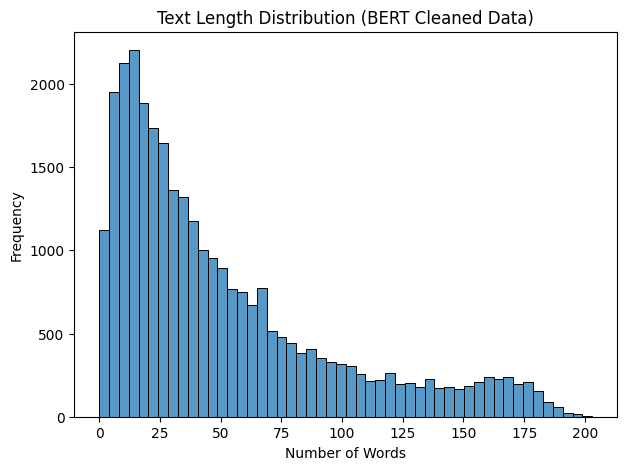

In [27]:
plt.figure(figsize=(7, 5))
sns.histplot(df_balanced["text_length"], bins=50)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Text Length Distribution (BERT Cleaned Data)")
plt.show()


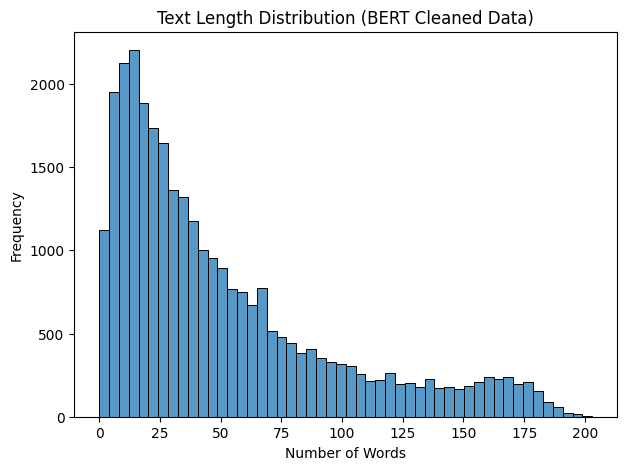

In [28]:
plt.figure(figsize=(7, 5))
sns.histplot(df_balanced["text_length"], bins=50)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Text Length Distribution (BERT Cleaned Data)")
plt.show()


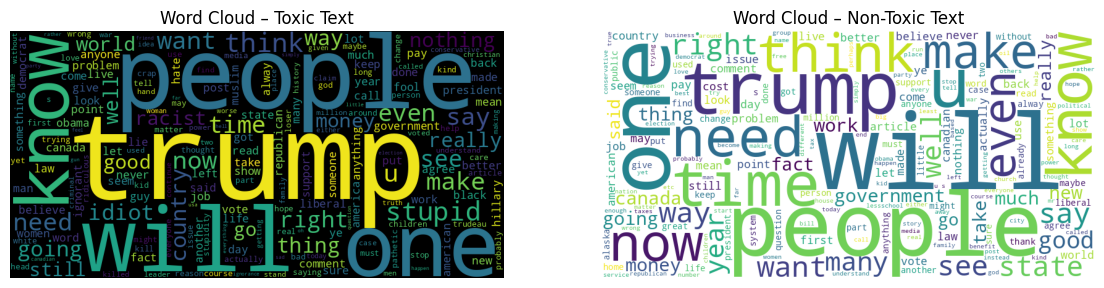

In [29]:
from wordcloud import WordCloud

toxic_text = " ".join(df_balanced[df_balanced["label"] == 1]["clean_text"])
nontoxic_text = " ".join(df_balanced[df_balanced["label"] == 0]["clean_text"])

wc_toxic = WordCloud(
    width=800, height=400,
    background_color="black"
).generate(toxic_text)

wc_nontoxic = WordCloud(
    width=800, height=400,
    background_color="white"
).generate(nontoxic_text)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(wc_toxic)
plt.axis("off")
plt.title("Word Cloud – Toxic Text")

plt.subplot(1, 2, 2)
plt.imshow(wc_nontoxic)
plt.axis("off")
plt.title("Word Cloud – Non-Toxic Text")

plt.show()


In [30]:
def bert_token_importance(text, label_names=["Non-Toxic", "Toxic"]):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[-1].mean(dim=1).mean(dim=1)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    token_scores = list(zip(tokens, attentions[0].numpy()))
    token_scores = sorted(token_scores, key=lambda x: x[1], reverse=True)

    return token_scores[:10]


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


import numpy as np
import pandas as pd
import torch

sample_indices = np.random.choice(len(X_test), 10, replace=False)

sample_texts = X_test.iloc[sample_indices]
sample_labels = y_test.iloc[sample_indices]

sample_encodings = tokenizer(
    list(sample_texts),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

sample_encodings = {key: val.to(device) for key, val in sample_encodings.items()}

model.eval()

with torch.no_grad():
    outputs = model(**sample_encodings)
    probabilities = torch.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

predictions = predictions.cpu().numpy()
probabilities = probabilities.cpu().numpy()

sample_predictions_df = pd.DataFrame({
    "Text": sample_texts.values,
    "Actual Label": sample_labels.values,
    "Predicted Label": predictions,
    "Toxic Probability": probabilities[:, 1].round(3)
})

sample_predictions_df



,Text,Actual Label,Predicted Label,Toxic Probability
0,not a simple 'bump on the noggin'.,0,0,0.000
1,"actually, the doctor stopped counting at 90 bu...",0,0,0.000
2,book em danno prayers for people this pos hurt...,0,0,0.000
3,"because i am familiar with the career, writing...",0,0,0.002
4,trump is crazy alright crazy like a genius fox...,1,1,0.999
5,except that policy directive is not yet in pla...,0,0,0.000
6,"yes, you've repeated this statement ad nauseum...",0,0,0.000
7,it is astounding that one actually has to read...,1,1,1.000
8,"finally ,a candidate with a brain !",0,0,0.001
9,i don't see why we would reject what works oth...,0,0,0.000


In [33]:
import os


In [34]:
save_path = "./bert_toxic_classifier"
os.makedirs(save_path, exist_ok=True)


In [35]:
model.save_pretrained(save_path)


In [36]:
tokenizer.save_pretrained(save_path)


('./bert_toxic_classifier/tokenizer_config.json',
 './bert_toxic_classifier/special_tokens_map.json',
 './bert_toxic_classifier/vocab.txt',
 './bert_toxic_classifier/added_tokens.json')

In [39]:
import joblib

bert_metadata = {
    "model": "BERT-base-uncased",
    "fine_tuned": True,
    "epochs": 3,
    "learning_rate": 2e-5,
    "accuracy": 0.94,
    "dataset": "mteb/toxic_conversations_50k"
}

joblib.dump(bert_metadata, "bert_model_metadata.pkl")


['bert_model_metadata.pkl']

In [40]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("./bert_toxic_classifier")
tokenizer = BertTokenizer.from_pretrained("./bert_toxic_classifier")
